# **Chess Analyzed**

### The data set used for this analysis consists of a record of chess matches played between similarly skilled players. It includes details about the games (inlcuding the move set and the players elo), categorized by the opening moves.

In [ ]:
# Imports
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

## Data Wrangling & Feature Engineering

Here, I wrangle the data as well as create the target feature: 'player-white-won'. This feature is a true or false value, where rows (rows = openings) where white accumulated more wins than the black pieces equates to True.

In [ ]:
# Reading in data:
url = 'https://gist.githubusercontent.com/zarekivey/efcf4fcd2a901b37dd9c8add58f5ebba/raw/fa8a35a3616975b824dde65af92a3e6bde9fd6ab/high_elo_opening.csv'
df = pd.read_csv(url, index_col='last_played_date', parse_dates=True)

# New Feature, the target: 
df['player_white_won'] = (df['white_wins'] > df['black_wins'])


# Columns dropped would cause leakage, have a high cardinality, or have no effect on the prediction.
df.drop(columns=['num_games','opening_name', 'ECO', 'perc_player_win','white_wins','black_wins', 'perc_white_win',
                  'pec_opponent_win', 'white_odds', 'moves_list', 'perc_black_win', 'white_odds', 'move4b', 'move4w'], inplace=True)

# Sorting the Index by date:
df = df.sort_values(by='last_played_date')
df.head()

,side,perf_rating,avg_player,perc_draw,move1w,move1b,move2w,move2b,move3w,move3b,player_white_won
last_played_date,,,,,,,,,,,
2010-04-10,white,2249,2243,25.5,e4,e5,Nf3,Nc6,Bc4,Bc5,False
2010-05-19,black,2214,2250,36.0,e4,e5,Bc4,Nf6,Nc3,Nxe4,True
2010-05-19,white,2184,2150,21.8,e4,e5,Bc4,Nf6,d4,exd4,True
2010-05-23,black,2286,2331,39.3,d4,f5,c4,Nf6,g3,e6,True
2010-05-25,black,2269,2281,26.1,e4,c5,Nf3,e6,d4,cxd4,False


## Splitting the Data & Establishing the Baseline.
The data is split by date, where the training data accounts for 70% of the values, the test data is 20%, and the validation includes 10% of the data. The baseline is established with the y_train values and returns a 80.7% accuracy. 

In [ ]:
# Splitting Data
target = 'player_white_won'
y = df[target]
X = df.drop(columns=target)

X_train, y_train = X['2018-06-18': '2018-07-09'], y['2018-06-18': '2018-07-09']
X_test, y_test = X['2018-04-23':'2018-06-17'], y['2018-04-23':'2018-06-17']
X_val, y_val = X['2010-04-10':'2018-04-22'], y['2010-04-10':'2018-04-22']

In [ ]:
# Baseline Accuracy:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accurracy:', baseline_acc)

Baseline Accurracy: 0.8074906367041198


## Hyperparameter Tuning & Tree Based Modeling.

In [ ]:
# Hyperparameter tuning with RSV:
estimator = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': [75, 100, 125],
    'randomforestclassifier__max_depth': range(10, 25, 10)
}
model_rs = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_iter=100,
    cv=3,
    n_jobs=-1,
    verbose=2
)
model_rs.fit(X_train, y_train);

In [ ]:
# Best Paramters: 
model_rs.best_params_

In [ ]:
# RF Model
model_rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100,
                           max_depth=20,
                           n_jobs=1,
                           random_state=42)
)

model_rf.fit(X_train, y_train)

In [ ]:
# Training and validation accuracy for RF.
train_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.7663043478260869


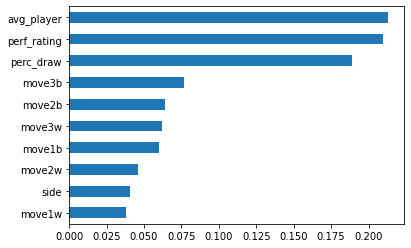

In [ ]:
# Visualizing Feature Importances
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

In [ ]:
# XGBoost Model:
model_xgb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, objective='reg:squarederror', n_jobs=-1)
)
model_xgb.fit(X_train, y_train);

In [ ]:
# Training and validation accuracy for XGB: 
print('Training accuracy:', model_xgb.score(X_train, y_train))
print('Validation accuracy:', model_xgb.score(X_val, y_val))

Training accuracy: 0.8771535580524344
Validation accuracy: 0.7663043478260869


## Linear Model


In [ ]:
model_lr = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    LinearRegression()
)

model_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['side', 'move1w', 'move1b', 'move2w',
                                     'move2b', 'move3w', 'move3b'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

## Visualizatios, Precision, Recall, and Accuracy.

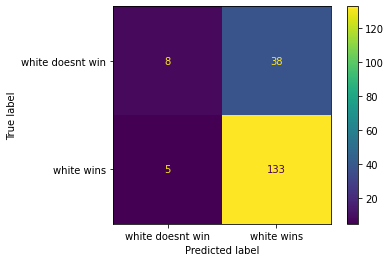

In [ ]:
# Confusion Matrix / Visulaizations:
plot_confusion_matrix(
    model_xgb,
    X_val, 
    y_val,
    values_format='.0f',
    display_labels=['white doesnt win', 'white wins']
);

In [ ]:
# Precision Accuracy and Recall:
print(classification_report(y_val,
                            model_xgb.predict(X_val),
                            target_names=['white doesnt win', 'white wins']))

                  precision    recall  f1-score   support

white doesnt win       0.62      0.17      0.27        46
      white wins       0.78      0.96      0.86       138

        accuracy                           0.77       184
       macro avg       0.70      0.57      0.57       184
    weighted avg       0.74      0.77      0.71       184

